# TensorFlow Tutorial #23
# Time-Series Prediction

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

This tutorial tries to predict the future weather of a city using weather-data from several other cities.

Because we will be working with sequences of arbitrary length, we will use a Recurrent Neural Network (RNN).

You should be familiar with TensorFlow and Keras in general, see Tutorials #01 and #03-C, and the basics of Recurrent Neural Networks as explained in Tutorial #20.

## Location

We will use weather-data from the period 1980-2018 for five cities in [Denmark](https://en.wikipedia.org/wiki/Denmark):

* **[Aalborg](https://en.wikipedia.org/wiki/Aalborg)** The weather-data is actually from an airforce base which is also home to [The Hunter Corps (Jægerkorps)](https://en.wikipedia.org/wiki/Jaeger_Corps_(Denmark)).
* **[Aarhus](https://en.wikipedia.org/wiki/Aarhus)** is the city where [the inventor of C++](https://en.wikipedia.org/wiki/Bjarne_Stroustrup) studied and the [Google V8 JavaScript Engine](https://en.wikipedia.org/wiki/Chrome_V8) was developed.
* **[Esbjerg](https://en.wikipedia.org/wiki/Esbjerg)** has a large fishing-port.
* **[Odense](https://en.wikipedia.org/wiki/Odense)** is the birth-city of the fairytale author [H. C. Andersen](https://en.wikipedia.org/wiki/Hans_Christian_Andersen).
* **[Roskilde](https://en.wikipedia.org/wiki/Roskilde)** has an old cathedral housing the tombs of the Danish royal family.

The following map shows the location of the cities in Denmark:

![Map of Denmark](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/Denmark.jpg?raw=1)

The following map shows the location of Denmark within Europe:

![Map of Europe](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/Europe.jpg?raw=1)

## Flowchart

In this tutorial, we are trying to predict the weather for the Danish city "Odense" 24 hours into the future, given the current and past weather-data from 5 cities (although the flowchart below only shows 2 cities).

We use a Recurrent Neural Network (RNN) because it can work on sequences of arbitrary length. During training we will use sub-sequences of 1344 data-points (8 weeks) from the training-set, with each data-point or observation having 20 input-signals for the temperature, pressure, etc. for each of the 5 cities. We then want to train the neural network so it outputs the 3 signals for tomorrow's temperature, pressure and wind-speed.

![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/23_time_series_flowchart.png?raw=1)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

We need to import several things from Keras.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

This was developed using Python 3.6 (Anaconda) and package versions:

In [3]:
tf.__version__

'2.8.2'

In [4]:
tf.keras.__version__

'2.8.0'

In [5]:
pd.__version__

'1.3.5'

## Load Data

Weather-data for 5 cities in Denmark will be downloaded automatically below.

The raw weather-data was originally obtained from the [National Climatic Data Center (NCDC), USA](https://www7.ncdc.noaa.gov/CDO/cdoselect.cmd). Their web-site and database-access is very confusing and may change soon. Furthermore, the raw data-file had to be manually edited before it could be read. So you should expect some challenges if you want to download weather-data for another region. The following Python-module provides some functionality that may be helpful if you want to use new weather-data, but you will have to modify the source-code to fit your data-format.

In [6]:
import weather

Download the data-set if you don't have it already. It is about 35 MB.

In [7]:
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


List of the cities used in the data-set.

In [8]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

Load and resample the data so it has observations at regular time-intervals for every 60 minutes. Missing data-points are linearly interpolated. This takes about 30 seconds to run the first time but uses a cache-file so it loads very quickly the next time.

In [9]:
%%time
df = weather.load_resampled_data()

CPU times: user 1min 25s, sys: 9.77 s, total: 1min 35s
Wall time: 1min 37s


These are the top rows of the data-set.

In [10]:
df.head()

Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889      NaN   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222      NaN   
1980-03-01 15:00:00  1008.100000      17.0   290.0  5.555556      NaN   

                                              Odense                          \
                     WindSpeed     WindDir      Temp     Pressure  WindSpeed   
DateTime                                                                       
1980-03-01 11:00:00  12.383333  310.000000  6.142857  1011.066667  12.585714   
1980-03-01 12:00:00  12.883333  310.000000  7.000000  1011.200000  11.300000   
1980-03-01 13:00:00  13.244444  309.444444  7.000000  1011.300000  12.118182   
1980-03-01 14:00:00  12.911111  306.111111  6.857143  1011.400000  12.742857   
1980-03-01 15:00:00  12.577778  302.777778  6.000000  1011.500000  12.400000   

                             Roskilde                                  
                    WindDir      Temp Pressure  WindSpeed     WindDir  
DateTime                                                               
1980-03-01 11:00:00   290.0  5.000000      NaN  11.466667  280.000000  
1980-03-01 12:00:00   290.0  5.000000      NaN  12.466667  280.000000  
1980-03-01 13:00:00   290.0  5.166667      NaN  13.133333  278.333333  
1980-03-01 14:00:00   290.0  5.833333      NaN  12.300000  270.000000  
1980-03-01 15:00:00   290.0  4.833333      NaN  12.300000  270.000000

### Missing Data

The two cities Esbjerg and Roskilde have missing data for the atmospheric pressure, as can be seen in the following two plots. 

Because we are using resampled data, we have filled in the missing values with new values that are linearly interpolated from the neighbouring values, which appears as long straight lines in these plots.

This may confuse the neural network. For simplicity, we will simply remove these two signals from the data.

But it is only short periods of data that are missing, so you could actually generate this data by creating a predictive model that generates the missing data from all the other input signals. Then you could add these generated values back into the data-set to fill the gaps.

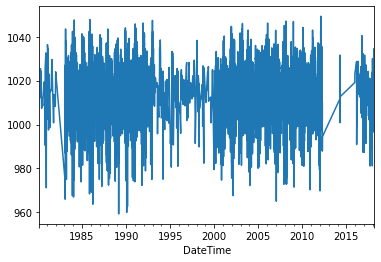

In [11]:
df['Esbjerg']['Pressure'].plot();

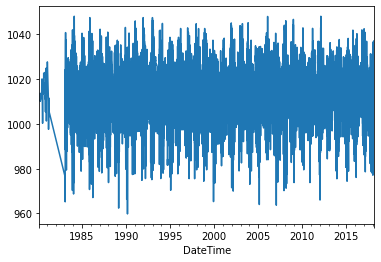

In [12]:
df['Roskilde']['Pressure'].plot();

Before removing these two signals, there are 20 input-signals in the data-set.

In [13]:
df.values.shape

(333109, 20)

Then we remove the two signals that have missing data.

In [14]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

Now there are only 18 input-signals in the data.

In [15]:
df.values.shape

(333109, 18)

We can verify that these two data-columns have indeed been removed.

In [16]:
df.head(1)

Aalborg                                Aarhus           \
                       Temp     Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                     
1980-03-01 11:00:00     5.0  1007.766667      10.2   280.0    5.0   1008.3   

                                        Esbjerg                       Odense  \
                    WindSpeed WindDir      Temp  WindSpeed WindDir      Temp   
DateTime                                                                       
1980-03-01 11:00:00      15.4   290.0  6.083333  12.383333   310.0  6.142857   

                                                    Roskilde             \
                        Pressure  WindSpeed WindDir     Temp  WindSpeed   
DateTime                                                                  
1980-03-01 11:00:00  1011.066667  12.585714   290.0      5.0  11.466667   

                             
                    WindDir  
DateTime                     
1980-03-01 11:00:00   280.0

### Data Errors

There are some errors in this data. As shown in the plot below, the temperature in the city of Odense suddenly jumped to almost 50 degrees C. But the highest temperature ever measured in Denmark was only 36.4 degrees Celcius and the lowest was -31.2 C. So this is clearly a data error. However, we will not correct any data-errors in this tutorial.

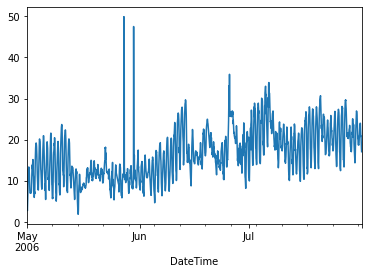

In [17]:
df['Odense']['Temp']['2006-05':'2006-07'].plot();

This can also be confirmed to be an error by considering the temperatures in some of the other cities in Denmark for that period, which was only around 10 degrees. Because the country is so small, it is not possible for one city in Denmark to have 50 degrees while another city only has 10 degrees.

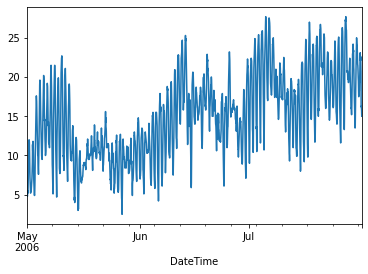

In [18]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot();

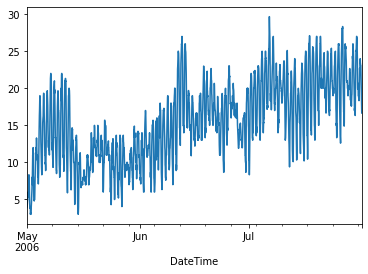

In [19]:
df['Roskilde']['Temp']['2006-05':'2006-07'].plot();

### Add Data

We can add some input-signals to the data that may help our model in making predictions.

For example, given just a temperature of 10 degrees Celcius the model wouldn't know whether that temperature was measured during the day or the night, or during summer or winter. The model would have to infer this from the surrounding data-points which might not be very accurate for determining whether it's an abnormally warm winter, or an abnormally cold summer, or whether it's day or night. So having this information could make a big difference in how accurately the model can predict the next output.

Although the data-set does contain the date and time information for each observation, it is only used in the index so as to order the data. We will therefore add separate input-signals to the data-set for the day-of-year (between 1 and 366) and the hour-of-day (between 0 and 23).

In [20]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

### Target Data for Prediction

We will try and predict the future weather-data for this city.

In [21]:
target_city = 'Odense'

We will try and predict these signals.

In [22]:
target_names = ['Temp', 'WindSpeed', 'Pressure']

The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation for each hour, so there are 24 observations for 24 hours.

If we want to predict the weather 24 hours into the future, we shift the data 24 time-steps. If we want to predict the weather 7 days into the future, we shift the data 7 * 24 time-steps.

In [23]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

Create a new data-frame with the time-shifted data.

**Note the negative time-shift!**

In [24]:
df_targets = df[target_city][target_names].shift(-shift_steps)

**WARNING!** You should double-check that you have shifted the data in the right direction! We want to predict the future, not the past!

The shifted data-frame is confusing because Pandas keeps the original time-stamps even though we have shifted the data. You can check the time-shift is correct by comparing the original and time-shifted data-frames.

This is the first `shift_steps + 5` rows of the original data-frame:

In [25]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556


The following is the first 5 rows of the time-shifted data-frame. This should be identical to the last 5 rows shown above from the original data, except for the time-stamp.

In [26]:
df_targets.head(5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000


The time-shifted data-frame has the same length as the original data-frame, but the last observations are `NaN` (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

In [27]:
df_targets.tail()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [28]:
x_data = df.values[0:-shift_steps]

In [29]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 20)


These are the output-signals (or target-signals):

In [30]:
y_data = df_targets.values[:-shift_steps]

In [31]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 3)


This is the number of observations (aka. data-points or samples) in the data-set:

In [32]:
num_data = len(x_data)
num_data

333085

This is the fraction of the data-set that will be used for the training-set:

In [33]:
train_split = 0.9

This is the number of observations in the training-set:

In [34]:
num_train = int(train_split * num_data)
num_train

299776

This is the number of observations in the test-set:

In [35]:
num_test = num_data - num_train
num_test

33309

These are the input-signals for the training- and test-sets:

In [36]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

333085

These are the output-signals for the training- and test-sets:

In [37]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

333085

This is the number of input-signals:

In [38]:
num_x_signals = x_data.shape[1]
num_x_signals

20

This is the number of output-signals:

In [39]:
num_y_signals = y_data.shape[1]
num_y_signals

3

### Scaled Data

The data-set contains a wide range of values:

In [40]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [41]:
x_scaler = MinMaxScaler()

We then detect the range of values from the training-data and scale the training-data.

In [42]:
x_train_scaled = x_scaler.fit_transform(x_train)

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [43]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


We use the same scaler-object for the input-signals in the test-set.

In [44]:
x_test_scaled = x_scaler.transform(x_test)

The target-data comes from the same data-set as the input-signals, because it is the weather-data for one of the cities that is merely time-shifted. But the target-data could be from a different source with different value-ranges, so we create a separate scaler-object for the target-data.

In [45]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has almost 300k observations, consisting of 20 input-signals and 3 output-signals.

These are the array-shapes of the input and output data:

In [46]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 3)


Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [47]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a large batch-size so as to keep the GPU near 100% work-load. You may have to adjust this number depending on your GPU, its RAM and your choice of `sequence_length` below.

In [48]:
batch_size = 256

We will use a sequence-length of 1344, which means that each random sequence contains observations for 8 weeks. One time-step corresponds to one hour, so 24 x 7 time-steps corresponds to a week, and 24 x 7 x 8 corresponds to 8 weeks.

In [49]:
sequence_length = 24 * 7 * 8
sequence_length

1344

We then create the batch-generator.

In [50]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

We can then test the batch-generator to see if it works.

In [51]:
x_batch, y_batch = next(generator)

This gives us a random batch of 256 sequences, each sequence having 1344 observations, and each observation having 20 input-signals and 3 output-signals.

In [52]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


We can plot one of the 20 input-signals as an example.

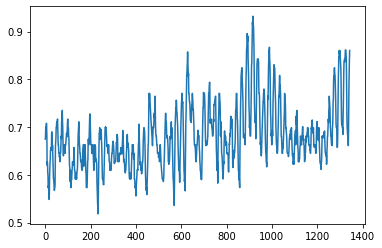

In [53]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 20 input signals.

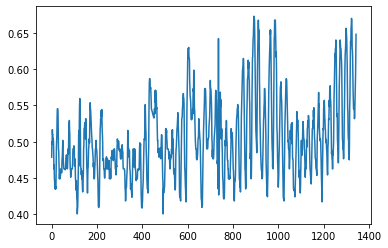

In [54]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [55]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. See Tutorial #03-C for a tutorial on Keras and Tutorial #20 for more information on Recurrent Neural Networks.

In [56]:
model = Sequential()

We can now add a Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [57]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

The GRU outputs a batch of sequences of 512 values. We want to predict 3 output-signals, so we add a fully-connected (or dense) layer which maps 512 values down to only 3 values.

The output-signals in the data-set have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [58]:
model.add(Dense(num_y_signals, activation='sigmoid'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid `NaN` values during training. You may need to experiment with this to get it working.

In [59]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [60]:
warmup_steps = 50

In [61]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [62]:
optimizer = RMSprop(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


We then compile the Keras model so it is ready for training.

In [63]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

This is a very small model with only two layers. The output shape of `(None, None, 3)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 3 signals. This corresponds to the 3 target signals we want to predict.

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 512)         820224    
                                                                 
 dense (Dense)               (None, None, 3)           1539      
                                                                 
Total params: 821,763
Trainable params: 821,763
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [65]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [66]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [67]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [68]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [69]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

With these settings, each "epoch" took about 2.5 minutes to process on a GTX 1070. After 14 "epochs" the optimization was stopped because the validation-loss had not decreased for 5 "epochs". This optimization took about 35 minutes to finish.

Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [70]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0084
Epoch 1: val_loss improved from inf to 0.00504, saving model to 23_checkpoint.keras
100/100 [==============================] - 69s 598ms/step - loss: 0.0084 - val_loss: 0.0050 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0049
Epoch 2: val_loss improved from 0.00504 to 0.00362, saving model to 23_checkpoint.keras
100/100 [==============================] - 62s 625ms/step - loss: 0.0049 - val_loss: 0.0036 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0040
Epoch 3: val_loss improved from 0.00362 to 0.00310, saving model to 23_checkpoint.keras
100/100 [==============================] - 62s 622ms/step - loss: 0.0040 - val_loss: 0.0031 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0036
Epoch 4: val_loss did not improve from 0.00310

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [71]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [72]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 1s 871ms/step - loss: 0.0022


In [73]:
print("loss (test-set):", result)

loss (test-set): 0.002174209337681532


In [74]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [75]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

We can now plot an example of predicted output-signals. It is important to understand what these plots show, as they are actually a bit more complicated than you might think.

These plots only show the output-signals and not the 20 input-signals used to predict the output-signals. The time-shift between the input-signals and the output-signals is held fixed in these plots. The model **always** predicts the output-signals e.g. 24 hours into the future (as defined in the `shift_steps` variable above). So the plot's x-axis merely shows how many time-steps of the input-signals have been seen by the predictive model so far.

The prediction is not very accurate for the first 30-50 time-steps because the model has seen very little input-data at this point.
The model generates a single time-step of output data for each time-step of the input-data, so when the model has only run for a few time-steps, it knows very little of the history of the input-signals and cannot make an accurate prediction. The model needs to "warm up" by processing perhaps 30-50 time-steps before its predicted output-signals can be used.

That is why we ignore this "warmup-period" of 50 time-steps when calculating the mean-squared-error in the loss-function. The "warmup-period" is shown as a grey box in these plots.

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

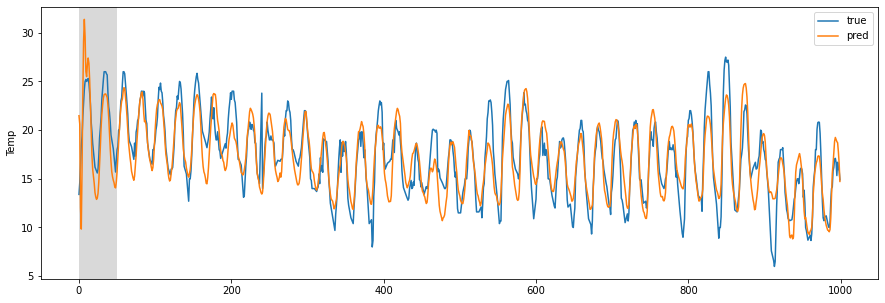

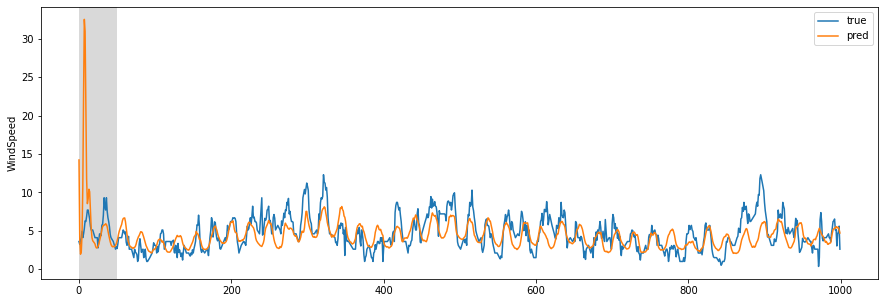

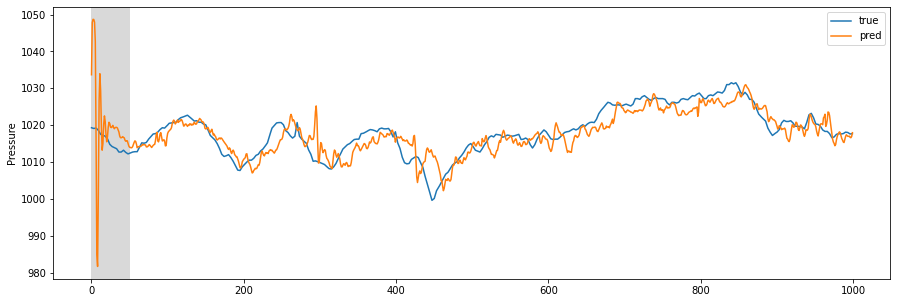

In [76]:
plot_comparison(start_idx=100000, length=1000, train=True)

The model was able to predict the overall oscillations of the temperature quite well but the peaks were sometimes inaccurate. For the wind-speed, the overall oscillations are predicted reasonably well but the peaks are quite inaccurate. For the atmospheric pressure, the overall curve-shape has been predicted although there seems to be a slight lag and the predicted curve has a lot of noise compared to the smoothness of the original signal.

### Strange Example

The following is another example from the training-set.

Note how the temperature does not oscillate very much within each day (this plot shows almost 42 days). The temperature normally oscillates within each day, see e.g. the plot above where the daily temperature-oscillation is very clear. It is unclear whether this period had unusually stable temperature, or if perhaps there's a data-error.

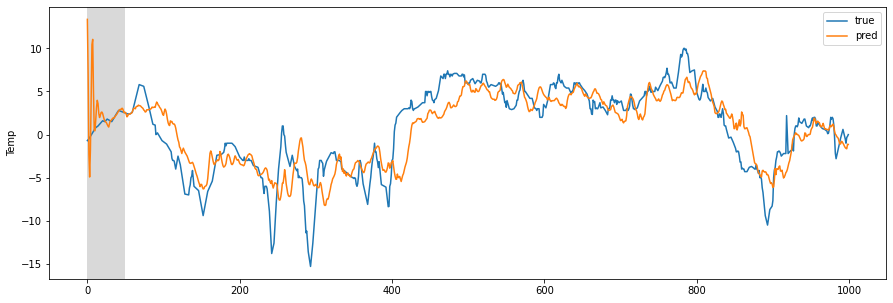

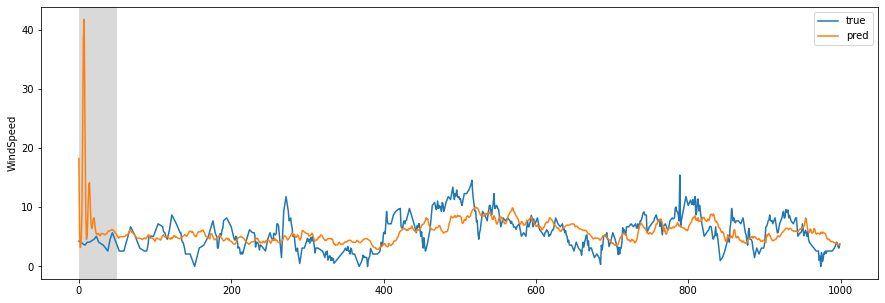

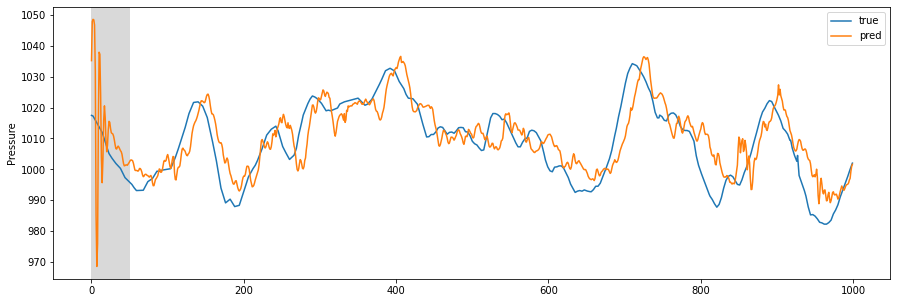

In [77]:
plot_comparison(start_idx=200000, length=1000, train=True)

As a check, we can plot this signal directly from the resampled data-set, which looks similar.

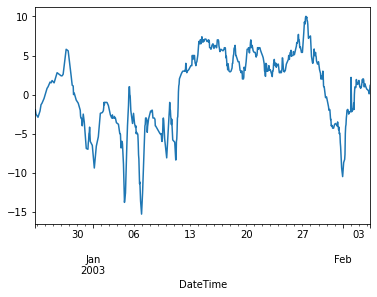

In [78]:
df['Odense']['Temp'][200000:200000+1000].plot();

We can plot the same period from the original data that has not been resampled. It also looks similar.

So either the temperature was unusually stable for a part of this period, or there is a data-error in the raw data that was obtained from the internet weather-database.

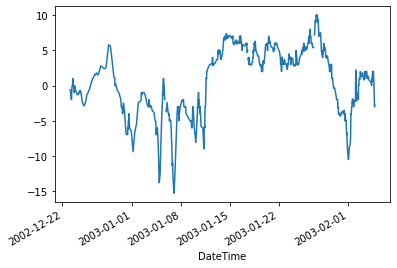

In [79]:
df_org = weather.load_original_data()
df_org.xs('Odense')['Temp']['2002-12-23':'2003-02-04'].plot();

### Example from Test-Set

Now consider an example from the test-set. The model has not seen this data during training.

The temperature is predicted reasonably well, although the peaks are sometimes inaccurate.

The wind-speed has not been predicted so well. The daily oscillation-frequency seems to match, but the center-level and the peaks are quite inaccurate. A guess would be that the wind-speed is difficult to predict from the given input data, so the model has merely learnt to output sinusoidal oscillations in the daily frequency and approximately at the right center-level.

The atmospheric pressure is predicted reasonably well, except for a lag and a more noisy signal than the true time-series.

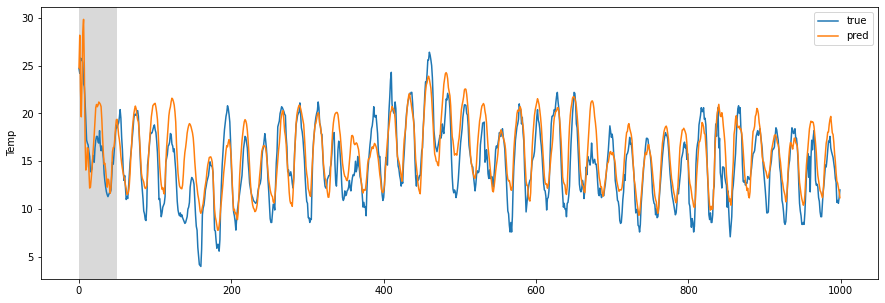

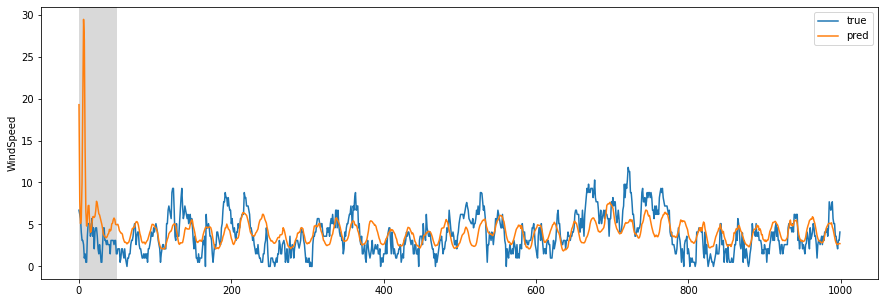

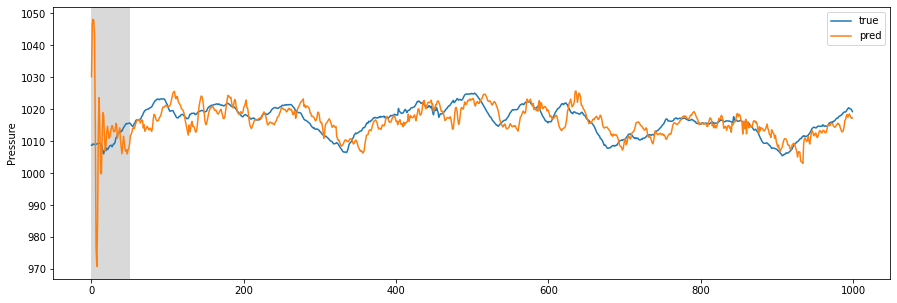

In [80]:
plot_comparison(start_idx=200, length=1000, train=False)

## Conclusion

This tutorial showed how to use a Recurrent Neural Network to predict several time-series from a number of input-signals. We used weather-data for 5 cities to predict tomorrow's weather for one of the cities.

It worked reasonably well for predicting the temperature where the daily oscillations were predicted well, but the peaks were sometimes not predicted so accurately. The atmospheric pressure was also predicted reasonably well, although the predicted signal was more noisy and had a short lag. The wind-speed could not be predicted very well.

You can use this method with different time-series but you should be careful to distinguish between *causation and correlation* in the data. The neural network may easily discover patterns in the data that are only temporary correlations which do not generalize well to unseen data.

You should select input- and output-data where a *causal* relationship probably exists. You should have a lot of data available for training, and you should try and reduce the risk of over-fitting the model to the training-data, e.g. using early-stopping as we did in this tutorial.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Remove the wind-speed from the target-data. Does it improve prediction for the temperature and pressure?
* Train for more epochs, possibly with a lower learning-rate. Does it improve the performance on the test-set?
* Try a different architecture for the neural network, e.g. higher or lower state-size for the GRU layer, more GRU layers, dense layers before and after the GRU layers, etc.
* Use hyper-parameter optimization from Tutorial #19.
* Try using longer and shorter sequences for the batch-generator.
* Try and remove the city "Odense" from the input-signals.
* Try and add last year's weather-data to the input-signals.
* How good is the model at predicting the weather 3 or 7 days into the future?
* Can you train a single model with the output-signals for multiple time-shifts, so that a single model predicts the weather in e.g. 1, 3 and 7 days.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.